## 1. Identificación de biomarcadores específicos de células malignas ductales

In [1]:
# Importaciones de los paquetes necesarios para la identificación de los biomarcadores
import os

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from Volcanoplot import volcano_plot
from Bio import ExPASy
from Bio import SwissProt

In [2]:
# Cargar la matriz anotada por Germán Vallejo Palma 
adata = sc.read_h5ad("/home/victor/Documentos/German/TFM_CODE/sc_rnaseq/Data/Peng_annotated.h5ad")
adata

AnnData object with n_obs × n_vars = 49966 × 2000
    obs: 'cell_name', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_prediction', 'cell_type_prediction_probability', 'per_cluster_celltype', 'per_cluster_proportion', 'Condition'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_prediction_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'per_cluster_celltype_colors', 'um

In [3]:
# Sustitución de T y N respecto a la condición por Tejido tumoral y tejido normal
adata.obs["CONDITION"]= adata.obs["Condition"].replace("T","Tejido tumoral")
adata.obs["CONDITION"]= adata.obs["CONDITION"].replace("N","Tejido normal")

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


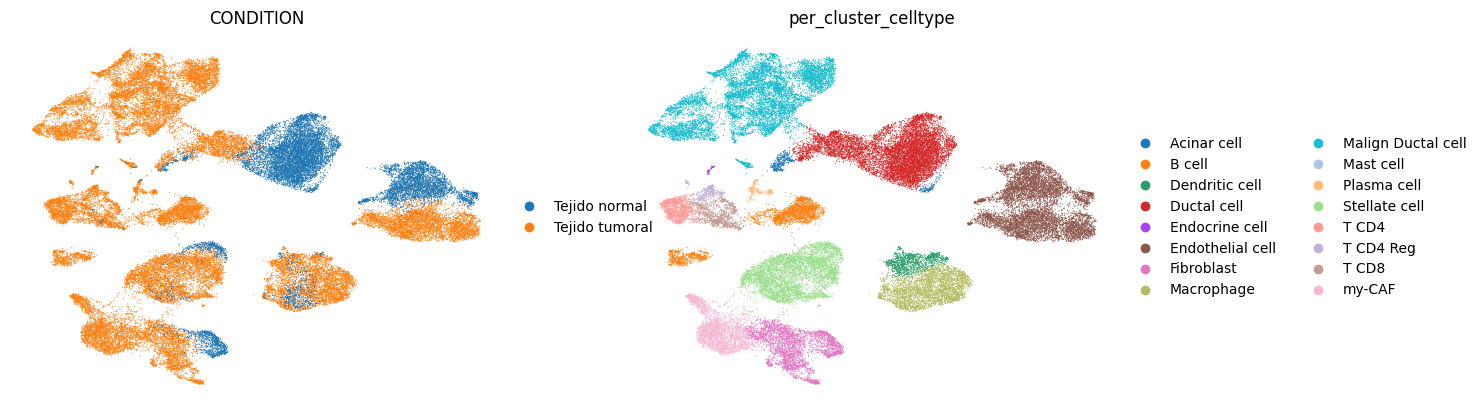

In [16]:
# Representación gráfica de las diferentes condiciones y tipos celulares con sus respectivas etiquetas
sc.pl.umap(adata, color = ['CONDITION','per_cluster_celltype'], frameon = False)

#### 1.1. Identificación de genes sobreexpresados en células tumorales

In [5]:
# Análisis Wilcoxon para calcular la expresión diferencial en tejido tumoral en comparación con el normal
sc.tl.rank_genes_groups(adata, 'CONDITION',groups=["Tejido tumoral"],reference="Tejido normal", method='wilcoxon', key_added="wilcoxon_tumor")

In [6]:
# Extracción del dataframe con los valores de expresión diferencial (nombre del gen, p-valor, p-valor ajustado, score y log2 Fold Change (FC)) y ordenados por FC
DEG_scanpy_tumor = sc.get.rank_genes_groups_df(adata, group="Tejido tumoral", key="wilcoxon_tumor")
DEG_scanpy_tumor.sort_values('logfoldchanges', ascending=False, inplace=True)
DEG_scanpy_tumor.head()

,names,scores,logfoldchanges,pvals,pvals_adj
216,TMPRSS4,32.301113,29.773897,6.747302e-229,2.939546e-227
702,CEACAM5,20.445572,29.053497,6.578367e-93,1.190005e-91
1003,LY6D,17.063597,28.652214,2.769633e-65,3.784009e-64
1267,CST1,14.944040,28.478062,1.703275e-50,1.904384e-49
1601,KLK6,13.225103,28.186508,6.285114e-40,5.838784e-39


/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


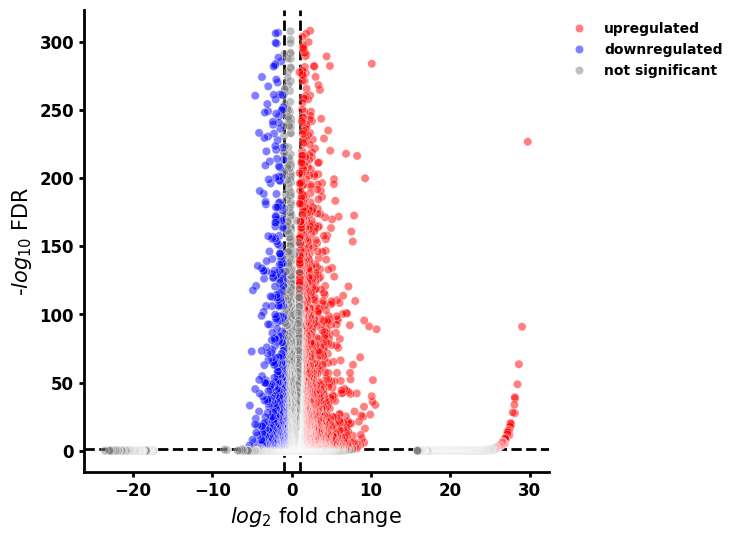

In [18]:
# Renombrado de las columnas para realizar el Volcano Plot
DEG_scanpy_tumor_volcano = DEG_scanpy_tumor.rename(columns={'pvals_adj': 'padj', 'logfoldchanges': 'log2FoldChange', 'names': 'gene_name'})

#Dibujo del Volcano para visualizar los genes
volcano_plot(DEG_scanpy_tumor_volcano, texto=[])

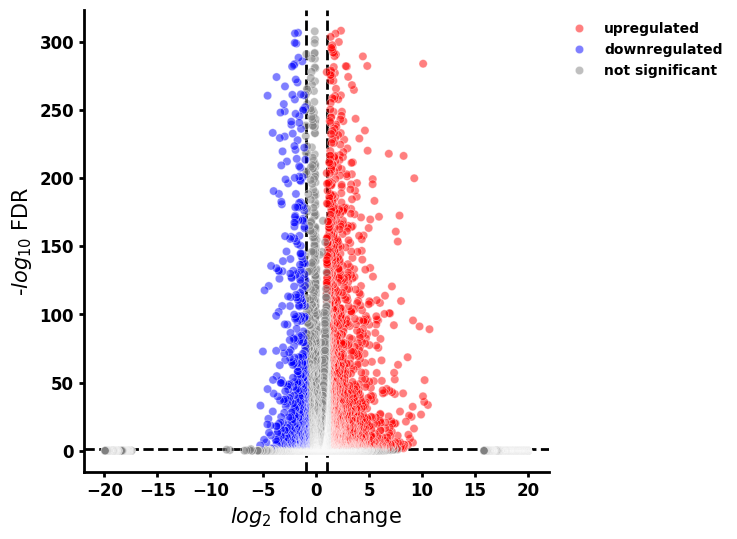

In [19]:
# Eliminar los outliers
outliers = DEG_scanpy_tumor_volcano.gene_name[abs(DEG_scanpy_tumor_volcano.log2FoldChange)>20].tolist()
DEG_scanpy_tumor_volcano_sinoutliers = DEG_scanpy_tumor_volcano[np.array([gen not in outliers for gen in DEG_scanpy_tumor_volcano.gene_name])].copy()

# Crear un volcano plot sin los outliers
volcano_plot(DEG_scanpy_tumor_volcano_sinoutliers,texto=[])

In [20]:
#  DEGS: seleccionar aquellos genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1
degs_scanpy_tumor=set(DEG_scanpy_tumor[(DEG_scanpy_tumor.pvals_adj<0.01)&(abs(DEG_scanpy_tumor.logfoldchanges)>1)].names.tolist())
degs_scanpy_tumor = list(degs_scanpy_tumor)

# Abrir el archivo en modo escritura y escribir la lista
with open("DEGS_tumor", 'w') as file:
    # Unir los elementos de la lista en una cadena con saltos de línea y escribir al archivo
    file.write('\n'.join(degs_scanpy_tumor))
    
print("Se encuentran ", len(degs_scanpy_tumor), " genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1")
print(degs_scanpy_tumor)

Se encuentran  3704  genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1
['PTPRN2', 'TFPT', 'MYOM1', 'DGUOK', 'FAM98A', 'RNF39', 'SLC6A6', 'AGPAT9', 'TMEM71', 'FCN1', 'GPR160', 'TYMS', 'C14orf105', 'C1QTNF3', 'ARL14', 'LINC00926', 'RNF126', 'LDHA', 'SAPCD2', 'TNFAIP8L2', 'TMEM54', 'PARP3', 'RNF24', 'EGLN3', 'PGP', 'RIPK3', 'HOXB3', 'BTK', 'CENPM', 'ZNF429', 'MST1', 'LINC00671', 'EDN1', 'SORBS2', 'TCN1', 'CCL19', 'MPP6', 'DCDC2', 'ZNF668', 'LPCAT4', 'RP11-43F13.3', 'RP11-462G2.1', 'RAB3B', 'CTA-363E6.2', 'BTLA', 'WNT5A', 'LGALS3BP', 'PRSS12', 'ZNF581', 'MXRA8', 'VSIG10L', 'RNF19B', 'AKNA', 'PABPC1', 'ZBTB7C', 'VMA21', 'RAB17', 'CXCL1', 'ZNF135', 'EPS8L3', 'OPN3', 'IFITM1', 'NME2', 'FGF1', 'LHFP', 'ATP8B2', 'NAV3', 'TUSC3', 'ALCAM', 'VPS37D', 'PDIA4', 'CFP', 'DNAJC10', 'RP11-290F20.3', 'MLLT11', 'CYB5R4', 'IGSF5', 'MSLN', 'HOXA-AS2', 'MIR142', 'RGS19', 'ARHGEF40', 'SLC25A30', 'TGM1', 'ARSB', 'PREB', 'KLF15', 'SRM', 'LGALS1', 'FABP1', 'TMEM133', 'NOP2', 'ARHGAP25', 'KCTD5', 'PFKF

#### 1.2. Identificación de genes sobreexpresados en células malignas ductales

In [16]:
# Análisis Wilcoxon para calcular la expresión diferencial en cada tipo celular en comparación con todo el resto
sc.tl.rank_genes_groups(adata, groupby='per_cluster_celltype', method='wilcoxon')

Se comienza con la selección de los genes que presentan sobreexpresión en células malignas ductales, aunque también puedan tener sobreexpresión en otros tipos celulares

In [17]:
# Extracción del dataframe con los valores de expresión diferencial (nombre del gen, p-valor, p-valor ajustado, score y log2 Fold Change (FC)) y ordenados por FC
DEG_scanpy_malign = sc.get.rank_genes_groups_df(adata, group="Malign Ductal cell")
DEG_scanpy_malign.sort_values('logfoldchanges', ascending=False, inplace=True)
DEG_scanpy_malign.head()

,names,scores,logfoldchanges,pvals,pvals_adj
10799,RP11-272B17.2,1.181388,24.568930,0.237448,0.399240
10949,AC005609.1,1.086877,24.393385,0.277091,0.458097
11255,LCE1E,0.897855,24.150883,0.369263,0.591693
11708,RP11-234B24.2,0.661577,23.694651,0.508242,0.776252
11816,UNC93A,0.614322,23.622492,0.539003,0.814475


In [18]:
#  DEGS: seleccionar aquellos genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1
degs_scanpy_malign =set(DEG_scanpy_malign[(DEG_scanpy_malign.pvals_adj<0.01)&(abs(DEG_scanpy_malign.logfoldchanges)>1)].names.tolist())
degs_scanpy_malign = list(degs_scanpy_malign)

# Guardar los genes como lista: abrir el archivo en modo escritura y escribir la lista
with open("DEGS_malign", 'w') as file:
    # Unir los elementos de la lista en una cadena con saltos de línea y escribir al archivo
    file.write('\n'.join(degs_scanpy_malign))
    
print("Se encuentran ", len(degs_scanpy_malign), " genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1 para células malignas ductales")
print(degs_scanpy_malign)

Se encuentran  6359  genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1 para células malignas ductales
['PLLP', 'P4HA1', 'CD69', 'NUFIP2', 'EZR', 'RP11-752G15.6', 'NMUR2', 'PYCARD', 'KIAA2013', 'F3', 'AADAC', 'GJB2', 'FAM160B2', 'TMEM68', 'ETV7', 'ATP2C2', 'HOGA1', 'ATP1B1', 'PPARG', 'STIL', 'GSE1', 'HOXA4', 'RALGAPB', 'TRIM16L', 'HIGD1B', 'C10orf35', 'KLC4', 'CAV1', 'RGMB-AS1', 'DUOX1', 'KIAA1147', 'RND3', 'BDH1', 'GPR56', 'ZCCHC24', 'PLAC8', 'IGF2BP3', 'KIAA0101', 'CCDC3', 'HPGD', 'MOCOS', 'DAPK2', 'TRPV6', 'BTBD1', 'SERPINA5', 'ZBTB33', 'HDHD1', 'CTSK', 'PAF1', 'MRAP2', 'LARP1B', 'ZNF165', 'TARS2', 'LIMA1', 'PHLDA2', 'NCEH1', 'TMEM208', 'SMIM7', 'NET1', 'HSPB2', 'MUC13', 'CTD-2228K2.5', 'C1orf131', 'ACSL6', 'ELTD1', 'ITGA9', 'HIST1H2AG', 'PHGDH', 'FOXD2-AS1', 'ADSSL1', 'CTD-2020K17.4', 'PCSK6', 'TMED5', 'PDIK1L', 'NLRP1', 'ZDHHC7', 'SLC2A1', 'REEP3', 'FANCA', 'RNF7', 'FBXW11', 'TMEM97', 'GALNT14', 'KLHL17', 'FERMT1', 'ELOVL1', 'GADD45G', 'PCDH9', 'PCDH12', 'ARPC1A', 'FAM21

Se filtra para que queden en el df únicamente los genes que presentan sobreexpresión en células malignas ductales pero no en el resto

In [19]:
# Nombrar los tipos celulares
TiposCelulares = ["Acinar cell", "B cell", "Dendritic cell", "Ductal cell", "Endocrine cell", "Endothelial cell", "Fibroblast", "Macrophage", "Malign Ductal cell", "Mast cell", "Plasma cell", "Stellate cell", "T CD4", "T CD4 Reg", "T CD8", "my-CAF"]

# Crear un data frame (df) vacío en el que se ponga como índice de cada fila el nombre del gen y en la columna tipo celular, en la celda se pondrá el logFC.
df_log = pd.DataFrame(index = degs_scanpy_malign, columns = TiposCelulares)

# Iterar sobre los tipos celulares
for Tipo in TiposCelulares:
    # Estraer de los resultados de la expresión diferencial para cada tipo celular
    result = sc.get.rank_genes_groups_df(adata, group=Tipo)
    # Obtener los genes y el logFC asociados a este tipo celular
    genes = result['names']
    logadj = result['logfoldchanges']
    
    # Asigna el lofFC para los genes específicos en el DataFrame
    for gene, log in zip(genes, logadj):
            df_log.at[gene, Tipo] = log

df_log.head(10)

,Acinar cell,B cell,Dendritic cell,Ductal cell,Endocrine cell,Endothelial cell,Fibroblast,Macrophage,Malign Ductal cell,Mast cell,Plasma cell,Stellate cell,T CD4,T CD4 Reg,T CD8,my-CAF
PLLP,0.520031,-3.876925,-4.179602,1.756363,0.139825,-1.098218,-3.371809,-3.029163,2.876242,-3.726863,-1.410673,-3.938553,-3.597594,-4.013241,-3.416716,-3.157237
P4HA1,-0.980565,-2.167868,-0.873961,-1.782529,1.758775,-0.885882,1.127432,0.685663,1.337212,-1.153817,-0.863652,-0.828782,-2.708508,-0.94903,-1.66519,2.796136
CD69,-0.988371,2.314226,1.246531,-2.665087,0.674751,-1.393975,-0.774602,1.035783,-1.36789,4.523591,1.52947,-0.943398,4.424096,2.282907,4.878614,-0.253729
NUFIP2,0.66603,-1.857656,-0.379352,0.075666,-0.746778,0.140994,-0.291614,0.077845,1.311329,-1.262147,-0.703061,-1.084313,-1.799053,-1.174841,-1.457663,-0.194923
EZR,0.820471,0.971239,-0.378184,0.584129,0.372658,-2.013081,-2.254927,-0.734187,2.764225,-1.006071,0.618371,-1.08094,-0.579117,1.026176,0.390933,-1.991846
RP11-752G15.6,-0.19678,0.219853,-0.784858,0.463493,1.935921,-0.774438,-0.179305,-0.955068,1.014732,1.077996,0.226047,-0.484395,-0.803079,-1.11231,-1.046942,-0.58449
NMUR2,-24.582617,-2.889688,-1.953799,-4.117563,-24.570536,-2.187721,-2.337191,-1.260912,4.556881,-24.570448,-1.184209,-2.278208,-24.606754,-1.457665,-24.60232,-2.420405
PYCARD,1.00009,-0.697368,2.9504,-0.346258,0.072707,-1.530159,-1.307463,2.924394,1.401109,-0.623404,0.595486,-1.748388,-1.307768,-0.517575,0.069716,-0.798267
KIAA2013,0.619264,-1.53018,-1.064733,-0.271655,1.366027,-0.029823,-0.076231,-0.075979,1.388472,-3.768989,-0.389294,-0.788207,-1.955372,-1.158374,-1.303255,0.151517
F3,0.548068,-3.174254,-2.263169,-2.277712,-0.884969,-2.663543,2.991156,-2.20231,2.677815,-1.483626,-0.347256,-0.352442,-2.412472,-2.386497,-2.344038,1.190238


In [20]:
# Filtrar las filas con valor mayor que 1 en la columna de células malignas ductales y cero en todas las demás columnas
DEG_scanpy_malign_exclusivo = df_log[(df_log['Malign Ductal cell'] > 1) & (df_log.drop('Malign Ductal cell', axis=1).lt(0).all(axis=1))]
print("Se encuentran ", len(DEG_scanpy_malign_exclusivo), " genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1 para células malignas ductales y log2 FC < 1 para el resto de tipos celulares")
# Imprimir las filas filtradas
DEG_scanpy_malign_exclusivo.head()

Se encuentran  976  genes con un p-valor ajustado menor de 0,01 y un log2 FC > 1 para células malignas ductales y log2 FC < 1 para el resto de tipos celulares


,Acinar cell,B cell,Dendritic cell,Ductal cell,Endocrine cell,Endothelial cell,Fibroblast,Macrophage,Malign Ductal cell,Mast cell,Plasma cell,Stellate cell,T CD4,T CD4 Reg,T CD8,my-CAF
NMUR2,-24.582617,-2.889688,-1.953799,-4.117563,-24.570536,-2.187721,-2.337191,-1.260912,4.556881,-24.570448,-1.184209,-2.278208,-24.606754,-1.457665,-24.60232,-2.420405
IGF2BP3,-1.224005,-0.572288,-2.29189,-4.48219,-1.470654,-3.197986,-3.223722,-1.393455,4.96681,-1.216112,-0.998298,-3.516414,-3.407374,-3.862293,-3.072195,-2.453876
MUC13,-1.965245,-2.07746,-1.59992,-2.181606,-0.675487,-2.298231,-1.804975,-1.653278,4.753501,-1.368489,-0.689076,-1.64039,-1.476845,-1.434254,-1.520025,-2.087017
BPIFB1,-2.534774,-3.031098,-1.527923,-3.071646,-24.722324,-1.927346,-0.688409,-0.96443,3.513716,-24.722237,-24.729759,-1.384337,-3.297222,-24.732088,-2.25743,-0.274476
CTD-2105E13.6,-23.779346,-3.396323,-2.175831,-6.090181,-23.767328,-3.172644,-1.453557,-3.833668,4.963172,-23.767241,-23.774714,-2.387113,-23.803356,-23.777029,-23.798944,-0.903828


In [21]:
degs_scanpy_malign_exclusivo = DEG_scanpy_malign_exclusivo.index.tolist()
# Guardar los genes como lista: abrir el archivo en modo escritura y escribir la lista
with open("DEGS_malign_exclusivo", 'w') as file:
    # Unir los elementos de la lista en una cadena con saltos de línea y escribir al archivo
    file.write('\n'.join(degs_scanpy_malign_exclusivo))

#### 1.3. Integración de datos de proteómica y sc-RNA-seq

Obtención del listado de marcadores intracelulares identificadas por Alejandra Gavier Moreno

In [12]:
os.chdir("/Users/Sara/Documents/TFM/Código para entregar")

# Leer el archivo con los ID de proteinas y localización
Proteinas_Intracelulares = pd.read_csv("proteins_intracellular.txt", sep='\t')

# Seleccionar la columna correspondiente a los ID de las proteínas y renombrarlo
Proteinas_Intracelulares = Proteinas_Intracelulares[["Proteina"]]
Proteinas_Intracelulares = Proteinas_Intracelulares.rename(columns={Proteinas_Intracelulares.columns[0] : "ID_Proteina"})
Proteinas_Intracelulares.head()

,ID_Proteina
0,O00115
1,O00425
2,O00469
3,O15195
4,O43633


In [13]:
# Definir una función para extraer el nombre 
def Proteinas_con_combre (Tabla_IDs):
    n=0
    for ID in Tabla_IDs["ID_Proteina"]:
        # Conectarse a la base de datos de SwissProt y guardar la información asociada a un ID de la proteina
        handle = ExPASy.get_sprot_raw(Tabla_IDs.at[n, "ID_Proteina"])
        # Guardar la información que lee de lo que ha buscado antes
        record = SwissProt.read(handle)
        # Asignar el nombre de la proteina y añadirlo a la tabla en una nueva columna "Nombre_Proteina"
        Proteina = record.entry_name
        Tabla_IDs.at[n,"Nombre_Proteina"] = Proteina
        # Busca en las referencias extraidas de la búsqueda que empiece con HGNC (HUGO Gene Nomenclature Committee),
        # si empieza por eso, el nombre se encuentra en el tercer elemento, lo guarda en una nueva columna de la tabla
        for reference in record.cross_references:
            if reference[0].startswith('HGNC'):
                Gen = reference[2]
                Tabla_IDs.at[n,"Nombre_Gen"] = Gen
                break
        n = n+1
    return(Tabla_IDs)

In [16]:
# Utilizar la función creada para obtener los normbres de los genes
TablaNombres = Proteinas_con_combre(Proteinas_Intracelulares)
TablaNombres.head()

,ID_Proteina,Nombre_Proteina,Nombre_Gen
0,O00115,DNS2A_HUMAN,DNASE2
1,O00425,IF2B3_HUMAN,IGF2BP3
2,O00469,PLOD2_HUMAN,PLOD2
3,O15195,VILL_HUMAN,VILL
4,O43633,CHM2A_HUMAN,CHMP2A


In [15]:
# Extraer los nombres de los genes intracelulares como lista
Genes_intracelulares = list(TablaNombres['Nombre_Gen'])
print(Genes_intracelulares)

['DNASE2', 'IGF2BP3', 'PLOD2', 'VILL', 'CHMP2A', 'TSPAN1', 'ASTN2', 'ALOX12B', 'BCAS1', 'SCEL', 'CLIC3', 'TSPAN13', 'KRT6A', 'FTL', 'KRT6B', 'KRT19', 'KRT7', 'KRT16', 'KRT3', 'P4HA1', 'CTSE', 'COX7A2', 'RAC2', 'NQO1', 'ITGA2', 'SDC1', 'MX1', 'CALB2', 'TBXAS1', 'S100P', 'AK4', 'S100A2', 'CRABP2', 'SERPINB3', 'PML', 'OAS2', 'S100A11', 'GBP2', 'THBS2', 'NNMT', 'SERPINB8', 'SERPINH1', 'PDLIM4', 'MYOM1', 'HK2', 'HK3', 'PTTG1IP', 'ATP5MF', 'CLDN18', 'ARPC4', 'LSM3', 'LSM6', 'ACTA2', 'VSNL1', 'DR1', 'TAGLN', 'KRT17', 'CALD1', 'BCL2L1', 'FHL3', 'TRIM29', 'FHL2', 'ITPR3', 'MFSD10', 'POSTN', 'NCF4', 'PLEC', 'DHCR24', 'CNN3', 'NRF1', 'HNRNPA1L2', 'SLC44A4', 'OCIAD2', 'SEL1L2', 'ANKRD22', 'ERAP2', 'TMCO3', 'TMC5', 'GALNT5', 'GALNT7', 'ZNF280B', 'AHNAK2', 'MISP', 'SULF2', 'SULF1', 'TNS4', 'VKORC1L1', 'CA13', 'H2BC26', 'SDR16C5', 'GSDMB', 'FBLIM1', 'PALLD', 'EVPL', 'CORO2A', 'H2BC1', 'ARMC5', 'CYP2S1', 'CNN2', 'PLIN2', 'C15orf48', 'DPY30', 'C19orf33', 'SH3BGRL3', 'S100A14', 'DECR2', 'MYO15A', 'ITGA1

In [26]:
Genes_membrana = ["SLC16A3", "S100A6", "PSCA", "CEACAM5", "RHOC", "CD55", "FCGR3A", "SLC2A1", "CEACAM1", "CD59", "ATP6V1B1", "NPR3", "LSP1", "BASP1", "MSLN", "ADAM9", "CEACAM7", "LY6E", "ANO1", "NCEH1", "GPRC5A", "HTRA1", "TMPRSS4", "MYOF", "NTM"]
print(Genes_membrana)

['SLC16A3', 'S100A6', 'PSCA', 'CEACAM5', 'RHOC', 'CD55', 'FCGR3A', 'SLC2A1', 'CEACAM1', 'CD59', 'ATP6V1B1', 'NPR3', 'LSP1', 'BASP1', 'MSLN', 'ADAM9', 'CEACAM7', 'LY6E', 'ANO1', 'NCEH1', 'GPRC5A', 'HTRA1', 'TMPRSS4', 'MYOF', 'NTM']


Comparación proteómica y sc-RNA-seq: comparación de DEGs y Proteinas expresadas diferencialemnte con p-valor ajustado < 0,01 y log2FC > 1

In [30]:
# Lista con genes que están en DEGs_tumor y genes de membrana
Genes_comunes_membrana_tumor = [gen for gen in degs_scanpy_tumor if gen in Genes_membrana]

# Lista con genes que están en DEGs_tumor pero no en genes de membrana
Genes_no_comunes_membrana_tumor = [gen for gen in Genes_membrana if gen not in degs_scanpy_tumor]

print("Hay", len(Genes_comunes_membrana_tumor), "DEGs tumorales comunes de membrana:", Genes_comunes_membrana_tumor)
print("Hay", len(Genes_no_comunes_membrana_tumor), "DEGs tumorales no comunes de membrana:", Genes_no_comunes_membrana_tumor)

Hay 20 DEGs tumorales comunes de membrana: ['SLC2A1', 'ADAM9', 'SLC16A3', 'FCGR3A', 'MYOF', 'PSCA', 'NTM', 'CD59', 'CD55', 'TMPRSS4', 'CEACAM5', 'GPRC5A', 'LY6E', 'CEACAM1', 'HTRA1', 'BASP1', 'ANO1', 'MSLN', 'LSP1', 'CEACAM7']
Hay 5 DEGs tumorales no comunes de membrana: ['S100A6', 'RHOC', 'ATP6V1B1', 'NPR3', 'NCEH1']


In [31]:
# Lista con genes que están en DEGs_tumor y genes intracelulares
Genes_comunes_intracelulares_tumor = [gen for gen in degs_scanpy_tumor if gen in Genes_intracelulares]

# Lista con genes que están en DEGs_tumor pero no en genes intracelulares
Genes_no_comunes_intracelulares_tumor = [gen for gen in Genes_intracelulares if gen not in degs_scanpy_tumor]

print("Hay", len(Genes_comunes_intracelulares_tumor), "DEGs tumorales comunes intracelulares:", Genes_comunes_intracelulares_tumor)
print("Hay", len(Genes_no_comunes_intracelulares_tumor), "DEGs tumorales no comunes intracelulares:", Genes_no_comunes_intracelulares_tumor)

Hay 76 DEGs tumorales comunes intracelulares: ['P4HA1', 'NNMT', 'IGF2BP3', 'SERPINB3', 'TBXAS1', 'SDR16C5', 'SULF1', 'OAS2', 'PLIN2', 'OAS3', 'CRABP2', 'CORO2A', 'MX1', 'CYP2S1', 'SCEL', 'ERAP2', 'TNS4', 'SLC44A4', 'HK2', 'BCAS1', 'KRT17', 'VILL', 'KRT6A', 'SDC1', 'COL17A1', 'S100P', 'KRT16', 'CTSE', 'GALNT7', 'SULF2', 'SH3BGRL3', 'CALB2', 'CNN2', 'CNN3', 'TMC5', 'NQO1', 'AHNAK2', 'GSDMB', 'ITGA2', 'VSNL1', 'DHCR24', 'AK4', 'RAC2', 'PLEC', 'PDLIM4', 'FBLIM1', 'EVPL', 'NCF4', 'KRT6B', 'C19orf33', 'THBS2', 'ITPR3', 'FHL3', 'SERPINB8', 'S100A2', 'CLDN18', 'SERPINH1', 'MISP', 'TSPAN1', 'ACTA2', 'MYOM1', 'FHL2', 'DR1', 'PALLD', 'GBP2', 'ARPC4', 'CLIC3', 'TAGLN', 'POSTN', 'C15orf48', 'ITGA11', 'GALNT5', 'ANKRD22', 'KRT19', 'PTTG1IP', 'TRIM29']
Hay 34 DEGs tumorales no comunes intracelulares: ['DNASE2', 'PLOD2', 'CHMP2A', 'ASTN2', 'ALOX12B', 'TSPAN13', 'FTL', 'KRT7', 'KRT3', 'COX7A2', 'PML', 'S100A11', 'HK3', 'ATP5MF', 'LSM3', 'LSM6', 'CALD1', 'BCL2L1', 'MFSD10', 'NRF1', 'HNRNPA1L2', 'OCIAD2'

Comparación de los marcadores identificados al comparar tumor vs normal con que tengan expresión diferencial en células malignas ductales con p-valor ajustado < 0,01 y log2FC > 1

In [32]:
# Lista con genes que están en DEGs_malign y genes de membrana
Genes_comunes_membrana_malign = [gen for gen in degs_scanpy_malign if gen in Genes_comunes_membrana_tumor]

# Lista con genes que están en DEGs_malign pero no en genes de membrana
Genes_no_comunes_membrana_malign = [gen for gen in Genes_comunes_membrana_tumor if gen not in degs_scanpy_malign]

print("Hay", len(Genes_comunes_membrana_malign), "DEGs de células malignas ductales comunes de membrana:", Genes_comunes_membrana_malign)
print("No hay", len(Genes_no_comunes_membrana_malign), "DEGs de células malignas ductales comunes de membrana:", Genes_no_comunes_membrana_malign)

Hay 19 DEGs de células malignas ductales comunes de membrana: ['SLC2A1', 'PSCA', 'CD55', 'TMPRSS4', 'LY6E', 'HTRA1', 'ANO1', 'FCGR3A', 'MYOF', 'GPRC5A', 'BASP1', 'ADAM9', 'SLC16A3', 'NTM', 'CEACAM1', 'CEACAM7', 'CEACAM5', 'MSLN', 'LSP1']
No hay 1 DEGs de células malignas ductales comunes de membrana: ['CD59']


In [33]:
# Lista con genes que están en DEGs_malign y genes intracelulares
Genes_comunes_intracelulares_malign = [gen for gen in degs_scanpy_malign if gen in Genes_comunes_intracelulares_tumor]

# Lista con genes que están en DEGs_malign pero no en genes intracelulares
Genes_no_comunes_intracelulares_malign = [gen for gen in Genes_comunes_intracelulares_tumor if gen not in degs_scanpy_malign]

print("Hay", len(Genes_comunes_intracelulares_malign), "DEGs de células malignas ductales comunes intracelulares:", Genes_comunes_intracelulares_malign)
print("No hay", len(Genes_no_comunes_intracelulares_malign), "DEGs de células malignas ductales comunes intracelulares:", Genes_no_comunes_intracelulares_malign)

Hay 59 DEGs de células malignas ductales comunes intracelulares: ['P4HA1', 'IGF2BP3', 'SDC1', 'COL17A1', 'S100P', 'CALB2', 'CNN3', 'AK4', 'FHL2', 'GALNT5', 'PTTG1IP', 'SDR16C5', 'OAS3', 'CRABP2', 'SCEL', 'BCAS1', 'VILL', 'TMC5', 'NQO1', 'THBS2', 'CLDN18', 'CLIC3', 'ITGA11', 'TRIM29', 'SULF1', 'MX1', 'CYP2S1', 'TNS4', 'KRT16', 'KRT6B', 'ITPR3', 'TSPAN1', 'POSTN', 'ANKRD22', 'KRT19', 'SERPINB3', 'OAS2', 'CORO2A', 'SLC44A4', 'HK2', 'KRT17', 'KRT6A', 'CTSE', 'GALNT7', 'AHNAK2', 'GSDMB', 'ITGA2', 'DHCR24', 'PLEC', 'PDLIM4', 'FBLIM1', 'EVPL', 'C19orf33', 'S100A2', 'MISP', 'MYOM1', 'DR1', 'GBP2', 'C15orf48']
No hay 17 DEGs de células malignas ductales comunes intracelulares: ['NNMT', 'TBXAS1', 'PLIN2', 'ERAP2', 'SULF2', 'SH3BGRL3', 'CNN2', 'VSNL1', 'RAC2', 'NCF4', 'FHL3', 'SERPINB8', 'SERPINH1', 'ACTA2', 'PALLD', 'ARPC4', 'TAGLN']


Comparación de los marcadores identificados al comparar tumor vs normal con que tengan expresión diferencial en células malignas ductales esclusivamente, es decir, con p-valor ajustado < 0,01 y     log2FC > 1 y log2FC < 0 en el resto de tipos celulares

In [34]:
# Lista con genes que están en DEGs_malign_exclusivos y genes de membrana
Genes_comunes_membrana_malign_exclusivo = [gen for gen in degs_scanpy_malign_exclusivo if gen in Genes_comunes_membrana_tumor]

# Lista con genes que están en DEGs_malign_exclusivos pero no en genes de membrana
Genes_no_comunes_membrana_malign_exclusivo = [gen for gen in Genes_comunes_membrana_tumor if gen not in degs_scanpy_malign_exclusivo]

print("Hay", len(Genes_comunes_membrana_malign_exclusivo), "DEGs de células malignas ductales comunes de membrana:", Genes_comunes_membrana_malign_exclusivo)
print("No hay", len(Genes_no_comunes_membrana_malign_exclusivo), "DEGs de células malignas ductales comunes de membrana:", Genes_no_comunes_membrana_malign_exclusivo)

Hay 3 DEGs de células malignas ductales comunes de membrana: ['PSCA', 'TMPRSS4', 'CEACAM5']
No hay 17 DEGs de células malignas ductales comunes de membrana: ['SLC2A1', 'ADAM9', 'SLC16A3', 'FCGR3A', 'MYOF', 'NTM', 'CD59', 'CD55', 'GPRC5A', 'LY6E', 'CEACAM1', 'HTRA1', 'BASP1', 'ANO1', 'MSLN', 'LSP1', 'CEACAM7']


In [35]:
DEG_scanpy_malign_filtrado_mem = DEG_scanpy_malign[DEG_scanpy_malign['names'].isin(Genes_comunes_membrana_malign_exclusivo)]
DEG_scanpy_malign_filtrado_mem

,names,scores,logfoldchanges,pvals,pvals_adj
44,TMPRSS4,86.039200,5.93387,0.0,0.0
233,CEACAM5,53.627037,5.29320,0.0,0.0
269,PSCA,50.821396,3.75967,0.0,0.0


In [36]:
# Lista con genes que están en DEGs_malign_exclusivos y genes intracelulares
Genes_comunes_intracelulares_malign_exclusivo = [gen for gen in degs_scanpy_malign_exclusivo if gen in Genes_comunes_intracelulares_tumor]

# Lista con genes que están en DEGs_malign_exclusivos pero no en genes intracelulares
Genes_no_comunes_intracelulares_malign_exclusivo = [gen for gen in Genes_comunes_intracelulares_tumor if gen not in degs_scanpy_malign_exclusivo]

print("Hay", len(Genes_comunes_intracelulares_malign_exclusivo), "DEGs exclusivos de células malignas ductales comunes intracelulares:", Genes_comunes_intracelulares_malign_exclusivo)
print("No hay", len(Genes_no_comunes_intracelulares_malign_exclusivo), "DEGs exclusivos de células malignas ductales comunes intracelulares:", Genes_no_comunes_intracelulares_malign_exclusivo)

Hay 8 DEGs exclusivos de células malignas ductales comunes intracelulares: ['IGF2BP3', 'COL17A1', 'SDR16C5', 'SCEL', 'VILL', 'KRT6B', 'CORO2A', 'EVPL']
No hay 68 DEGs exclusivos de células malignas ductales comunes intracelulares: ['P4HA1', 'NNMT', 'SERPINB3', 'TBXAS1', 'SULF1', 'OAS2', 'PLIN2', 'OAS3', 'CRABP2', 'MX1', 'CYP2S1', 'ERAP2', 'TNS4', 'SLC44A4', 'HK2', 'BCAS1', 'KRT17', 'KRT6A', 'SDC1', 'S100P', 'KRT16', 'CTSE', 'GALNT7', 'SULF2', 'SH3BGRL3', 'CALB2', 'CNN2', 'CNN3', 'TMC5', 'NQO1', 'AHNAK2', 'GSDMB', 'ITGA2', 'VSNL1', 'DHCR24', 'AK4', 'RAC2', 'PLEC', 'PDLIM4', 'FBLIM1', 'NCF4', 'C19orf33', 'THBS2', 'ITPR3', 'FHL3', 'SERPINB8', 'S100A2', 'CLDN18', 'SERPINH1', 'MISP', 'TSPAN1', 'ACTA2', 'MYOM1', 'FHL2', 'DR1', 'PALLD', 'GBP2', 'ARPC4', 'CLIC3', 'TAGLN', 'POSTN', 'C15orf48', 'ITGA11', 'GALNT5', 'ANKRD22', 'KRT19', 'PTTG1IP', 'TRIM29']


In [37]:
DEG_scanpy_malign_filtrado_intra = DEG_scanpy_malign[DEG_scanpy_malign['names'].isin(Genes_comunes_intracelulares_malign_exclusivo)]
DEG_scanpy_malign_filtrado_intra

,names,scores,logfoldchanges,pvals,pvals_adj
175,SDR16C5,59.400848,5.842683,0.000000e+00,0.000000e+00
1176,IGF2BP3,26.906103,4.966810,1.863195e-159,2.710666e-158
2192,SCEL,19.402590,4.948724,7.337898e-84,6.092917e-83
274,COL17A1,50.571098,4.825157,0.000000e+00,0.000000e+00
428,CORO2A,42.935673,4.543438,0.000000e+00,0.000000e+00
148,VILL,63.806671,4.364094,0.000000e+00,0.000000e+00
1996,KRT6B,20.434818,3.944731,8.199639e-93,7.380290e-92
860,EVPL,31.405081,3.606549,1.724706e-216,3.330778e-215


#### 1.4. Análisis gráfico de la especificidad de los marcadores

In [44]:
# Mezcla de los marcadores de membrana e intracelulares
marcadores = Genes_comunes_membrana_malign_exclusivo + Genes_comunes_intracelulares_malign_exclusivo
print(marcadores)

['PSCA', 'TMPRSS4', 'CEACAM5', 'IGF2BP3', 'COL17A1', 'SDR16C5', 'SCEL', 'VILL', 'KRT6B', 'CORO2A', 'EVPL']


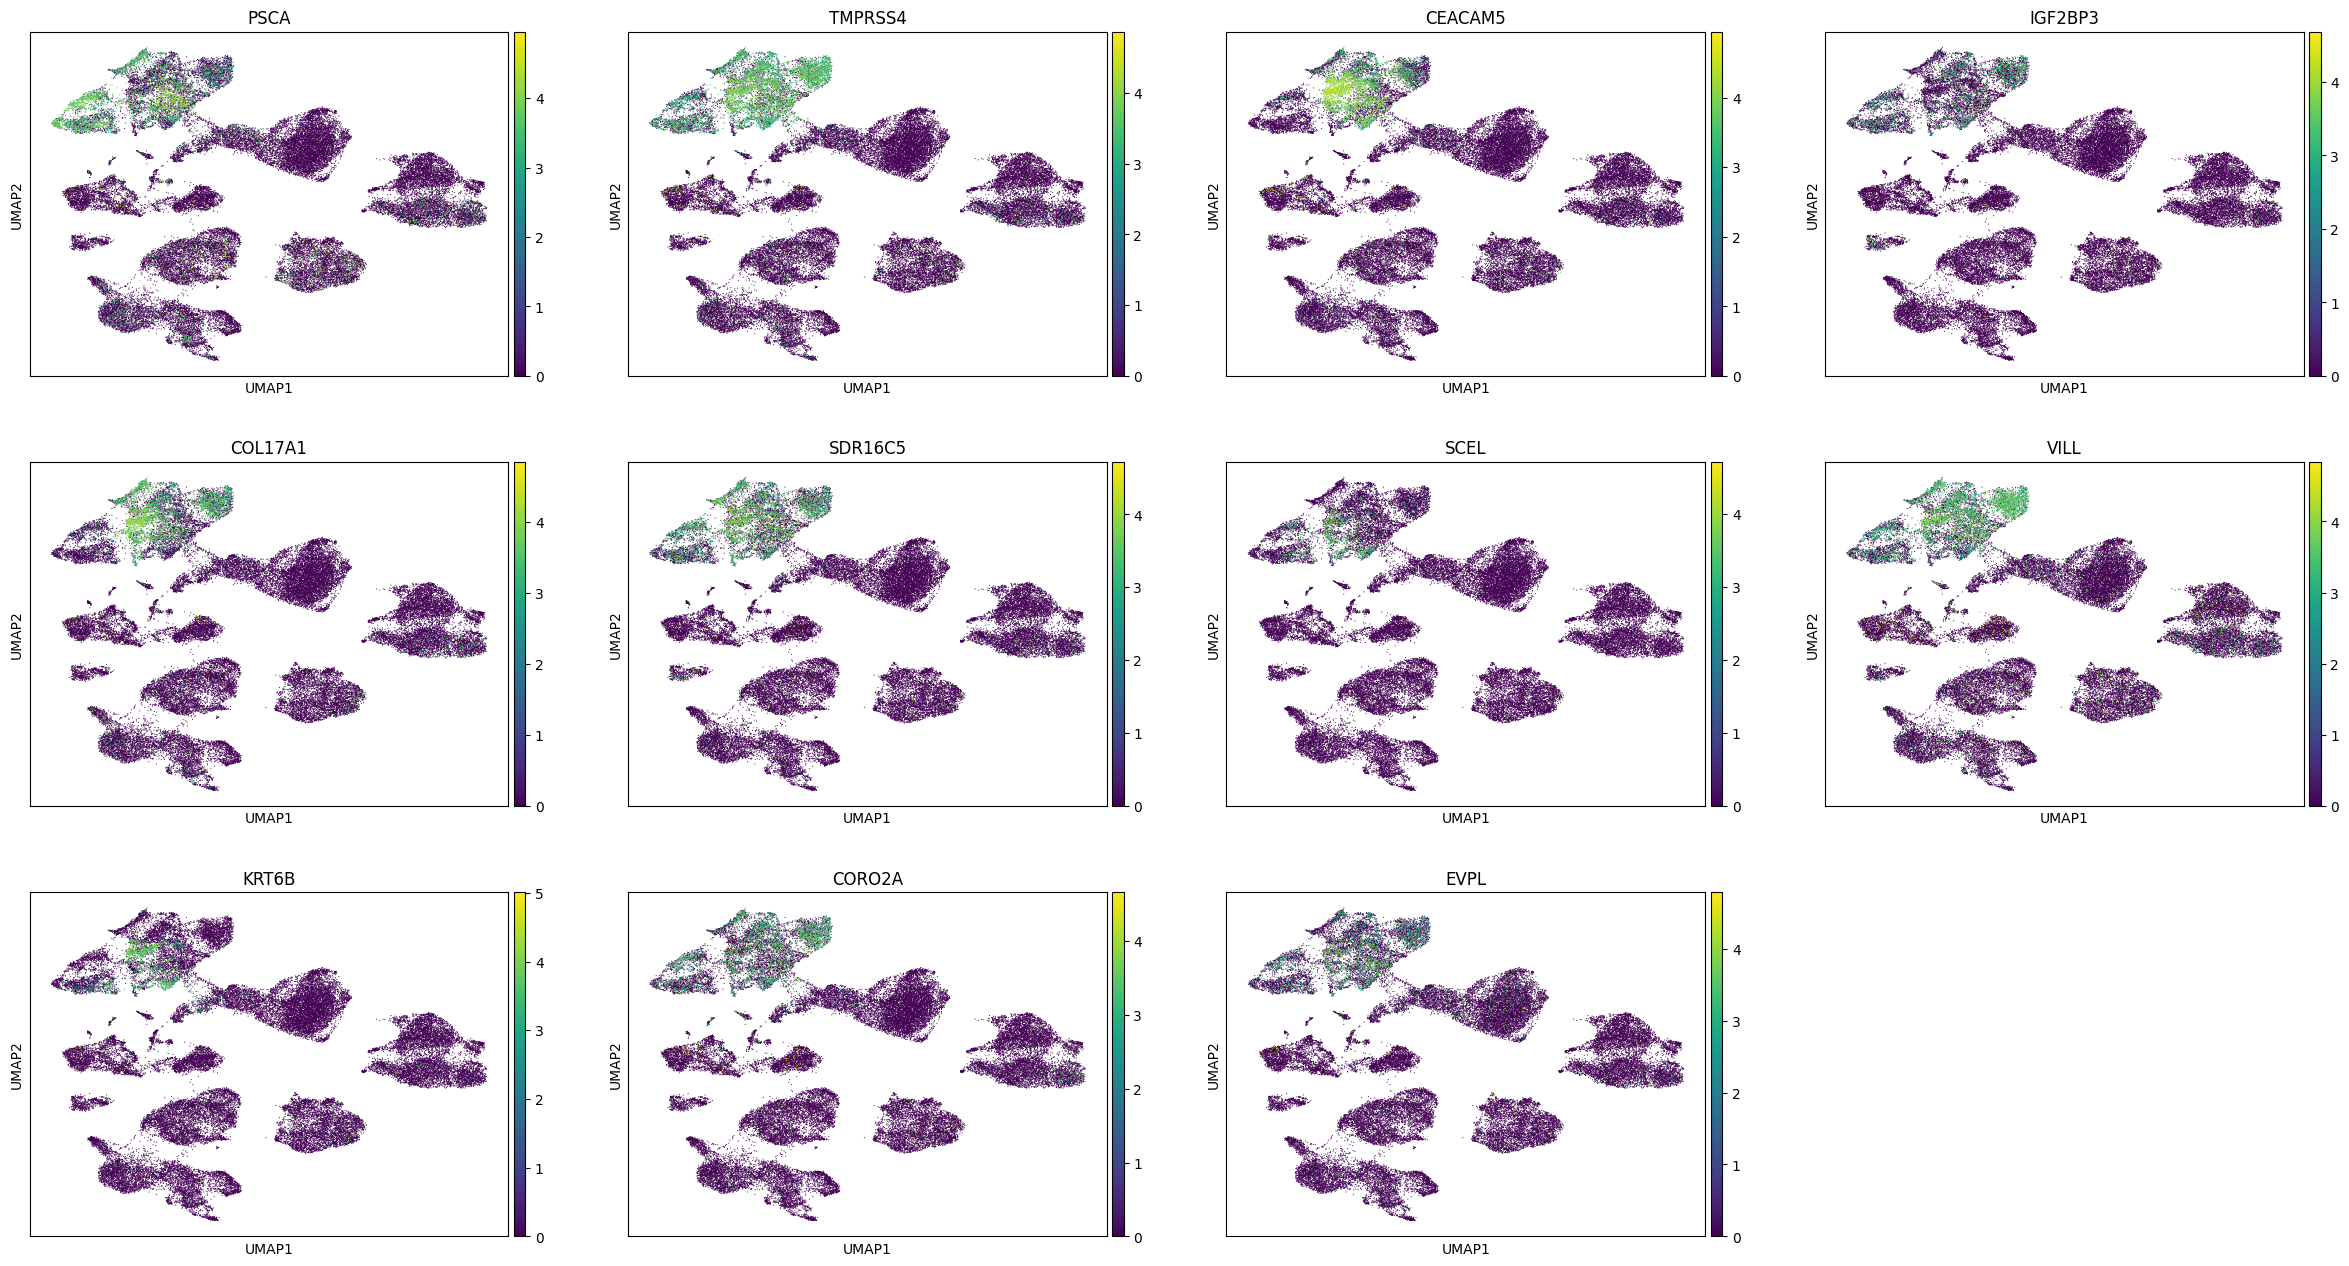

In [45]:
# Representación UMAP de los marcadores identificados
sc.pl.umap(adata, color= marcadores, use_raw=True, save="_Umaps.png")

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


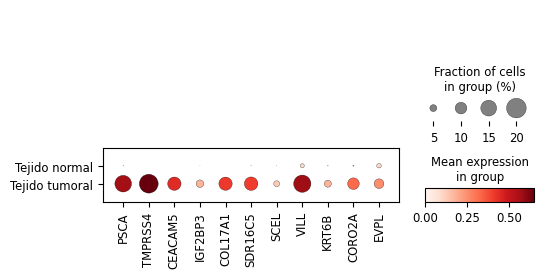

In [47]:
# Representación dotplot de los marcadores identificados en función de su condición
sc.pl.dotplot(adata, marcadores, groupby="CONDITION", save="_DotplotCondicion.png")

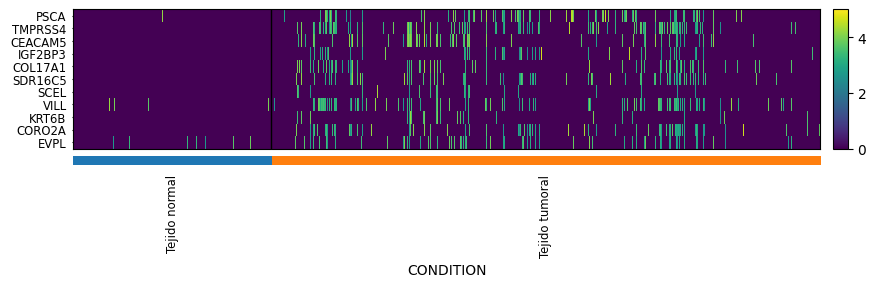

In [48]:
# Representación heatmap de los marcadores identificados en función de su condición
sc.pl.heatmap(adata, marcadores, swap_axes=True, groupby="CONDITION", save="_HeatmapCondicion.png")

/home/victor/miniconda3/envs/sc_rnaseq/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


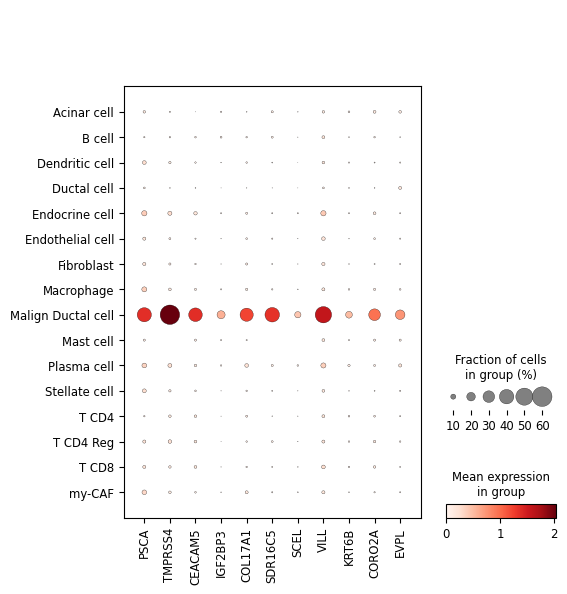

In [49]:
# Representación dotplot de los marcadores identificados en función del tipo celular
sc.pl.dotplot(adata, marcadores, groupby="per_cluster_celltype", save="_DotplotTipo.png")

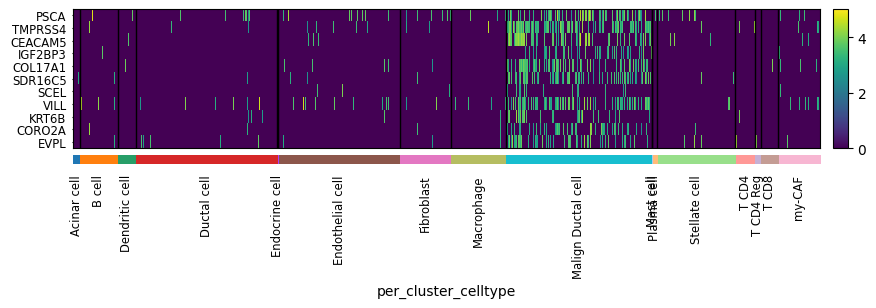

In [50]:
# Representación heatmap de los marcadores identificados en función del tipo celular
sc.pl.heatmap(adata, marcadores, swap_axes=True, groupby="per_cluster_celltype", save="_HeatmapTipo.png")